<a href="https://colab.research.google.com/github/25ab/NFT-generation/blob/main/NFT_generation(art).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import random
from tqdm import tqdm
import cv2 as cv
import PIL
from PIL import Image
!pip install plotly
import plotly.express as px
from IPython import display

import tensorflow as tf
from tensorflow import keras

import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import requests # request img from web
import shutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!rm -R /content/sample_data/photo/.ipynb_checkpoints

In [ ]:
from google.colab import files 
  
  
uploaded = files.upload()

Saving json-to-csv.csv to json-to-csv.csv


In [ ]:
url="https://ipfs.io/ipfs/Qme57kZ2VuVzcj5sC3tVHFgyyEgBTmAnyTK45YVNxKf6hi"
import io 
df = pd.read_csv(io.BytesIO(uploaded['json-to-csv.csv']),delimiter=';') 

In [ ]:
df.head()

tokenId                                              image  \
0        0  https://ipfs.io/ipfs/QmdUXVtRxKhdVhjPXCUxZGyXN...   
1        1  https://ipfs.io/ipfs/QmRL5ve3u7aN9RFMTmV1vWb6x...   
2        2  https://ipfs.io/ipfs/QmVEGtJGAKmYZyYMQAHqebPMf...   
3        3  https://ipfs.io/ipfs/QmTb52c3ks8R1pif7L56sCYXX...   
4        4  https://ipfs.io/ipfs/QmYt4Nab7Lxe3sQ78UKfV1bnV...   

                                           imageHash traits/Background  \
0  c92b0386542d8beb8fb167aed611e73c5f30250a083f54...            Orange   
1  ba2ea17148a6b4fd17df39b4c5531d860c565f465c8662...              Gray   
2  7edf3c2c26498ead3f4144c5d43509bbbaa2317edc3571...              Blue   
3  6e89bf24717b39009dd7b8e742018602a7adb32762c27e...            Purple   
4  a5a2a50e5ff57ae1234f4a8fa4c2630e9a215d46aa4bed...            Purple   

       traits/Hat traits/Eyes    traits/Clothes     traits/Mouth  traits/Fur  \
0  Bayc Hat Black      Sleepy          Lab Coat            Bored       Black   
1             NaN       Angry       Striped Tee           Jovial         Tan   
2           Horns      Closed        Bayc T Red  Bored Cigarette         Red   
3   Laurel Wreath      Closed    Vietnam Jacket   Bored Unshaven  Dark Brown   
4          Beanie       Bored  Lumberjack Shirt            Bored         Dmt   

  traits/Earring  
0            NaN  
1            NaN  
2    Silver Hoop  
3            NaN  
4            NaN

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


n=2000
img1=df["image"]
X_data = []

for i in range(n) :
  response = requests.get(img1.iloc[i],stream=True)

  with open("/content/sample_data/photo/photos/photo["+str(i)+"].png","wb") as f:
       shutil.copyfileobj(response.raw, f)


  



In [ ]:
image_dir  = "/content/sample_data/photo"
image_root ="/content/sample_data/photo"

In [ ]:
base_dir = "/content/sample_data/photo"

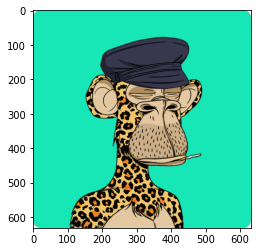

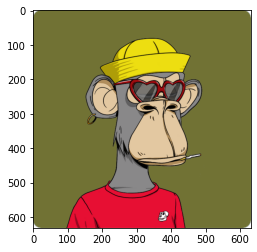

In [ ]:
NFTs = [img for img in glob.glob("/content/sample_data/photo/photos/*.png")]

for NFT in NFTs[0:2]:
    img = plt.imread(NFT)
    plt.imshow(img)
    plt.show()

In [ ]:
def tensor_imshow(img, dnorm=True):
    img = img.to('cpu')
    npimg = img.detach().numpy()
    if dnorm:
        npimg = npimg*0.5+0.5
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
def get_dataloader(batch_size,           #batch size during training
                   image_size,           #spatial size of training images
                   data_dir,   #root directory for dataset
                   num_workers=3):       #number of sub-processes
    
    
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) 
    transform = transforms.Compose([transforms.Resize((image_size, image_size)),  #resize
                                    transforms.ToTensor(),                        #convert to tensor
                                    transforms.Normalize(*stats)])                #normalize to be between -1 and 1
    print(image_dir)
    dataset = datasets.ImageFolder(root=data_dir,transform=transform)
    
                                   
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=num_workers,
                                              pin_memory=True)
    
    return data_loader

/content/sample_data/photo
/content/sample_data/photo


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


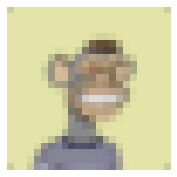

In [ ]:
batch_size, image_size = 5, 24
print (image_root)
train_loader = get_dataloader(batch_size,
                              image_size,"/content/sample_data/photo/")

dataiter = iter(train_loader) #dataloader is an iterator

img,_ = next(dataiter)
sample_img = img[-1]

#display tensor image
tensor_imshow(sample_img)

In [ ]:
class Generator(nn.Module):       #signals neural network
    def __init__(self, 
                 z_dim=100,      #noise vector
                 im_chan=3,      #color chanel, 3 for red green blue
                 hidden_dim=64): #spatial size of feature map (conv)
        
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.im_chan = im_chan
        self.hidden_dim = hidden_dim
        
        self.generator_cnn = nn.Sequential(self.make_gen_block(z_dim, hidden_dim*8, stride=1, padding=0),   
                                           #(64*8) x 4 x 4
                                           self.make_gen_block(hidden_dim*8, hidden_dim*4),                           
                                           #(64*4) x 8 x 8
                                           self.make_gen_block(hidden_dim*4, hidden_dim*2),                           
                                           #(64*2) x 16 x 16
                                           self.make_gen_block(hidden_dim*2, hidden_dim),                             
                                           #(64) x 32 x 32
                                           self.make_gen_block(hidden_dim, im_chan, final_layer=True))
    
    def make_gen_block(self, 
                       im_chan,     #image dimension
                       op_chan,     #output dimension
                       kernel_size=4, 
                       stride=2, 
                       padding=1, 
                       final_layer=False): 
        
        layers = []
        #de-convolutional layer
        layers.append(nn.ConvTranspose2d(im_chan,     
                                         op_chan, 
                                         kernel_size, 
                                         stride, 
                                         padding, 
                                         bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2))
        else:
            layers.append(nn.Tanh())
        
        return nn.Sequential(*layers)
    
    def forward(self,noise):
        x = noise.view(-1,self.z_dim,1,1)
        return self.generator_cnn(x)

    def get_noise(n_samples, 
                  z_dim, 
                  device='cpu'):
        return torch.randn(n_samples, 
                           z_dim, 
                           device=device)

In [ ]:
noise = Generator.get_noise(n_samples=5,
                            z_dim=100)

g = Generator(z_dim=100,
              im_chan=3,
              hidden_dim=64)


In [ ]:
print(g)

Generator(
  (generator_cnn): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, 
                 im_chan=3,       #image channels, 3 for red green blue
                 conv_dim=64,     #spatial dimension of feature map
                 image_size=64):  #spatial size of training images
        
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.conv_dim = conv_dim
        
        self.disc_cnn = nn.Sequential(self.make_disc_block(im_chan, conv_dim),
                                      self.make_disc_block(conv_dim, conv_dim*2),
                                      self.make_disc_block(conv_dim*2, conv_dim*4),
                                      self.make_disc_block(conv_dim*4, conv_dim*8),
                                      #no need a sigmoid here since it is included in the loss function
                                      self.make_disc_block(conv_dim*8, 1, padding=0, final_layer=True)) 
        
        
    def make_disc_block(self,
                        im_chan,
                        op_chan,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        final_layer=False):
        layers = []
        layers.append(nn.Conv2d(im_chan,
                                op_chan,
                                kernel_size,
                                stride,
                                padding,
                                bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return nn.Sequential(*layers)
    
    #given an image tensor, returns a 1-dimension tensor representing fake/real
    def forward(self,image):
        pred = self.disc_cnn(image)
        pred = pred.view(image.size(0),-1)
        return pred
    
    def _get_final_feature_dimention(self):
        final_width_height = (self.image_size //  2**len(self.disc_cnn))**2
        final_depth = self.conv_dim * 2**(len(self.disc_cnn)-1)
        return final_depth*final_width_height

In [ ]:
d = Discriminator(im_chan=3,
                  conv_dim=64,
                  image_size=64)

In [ ]:
print(d)

Discriminator(
  (disc_cnn): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affi

In [ ]:
def weights_init_normal(m):
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02) 
        
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
def real_loss(D_out,device='cpu'):
    
    #initialize BCELoss function
    criterion = nn.BCEWithLogitsLoss()
    
    #batch size
    batch_size = D_out.size(0)
    
    #labels will be used when calculating the losses
    #real labels = 1 and lable smoothing => 0.9
    labels = torch.ones(batch_size, device=device)*0.9 
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
def fake_loss(D_out, device='cpu'):
    
    #initialize BCELoss function
    criterion = nn.BCEWithLogitsLoss()
    
    #batch size
    batch_size = D_out.size(0)
    
    #labels will be used when calculating the losses
    #fake labels = 0
    labels = torch.zeros(batch_size,
                         device=device) 
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
def print_tensor_images(images_tensor):
    
    '''
    Function for visualizing images: Given a tensor of images, prints the images.
    '''
        
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    images_tensor = images_tensor.to('cpu')
    npimgs = images_tensor.detach().numpy()
    
    no_plots = len(images_tensor)

    for idx,image in enumerate(npimgs):
        plt.subplot(1, 8, idx+1)
        plt.axis('off')
        #dnorm
        image = image * 0.5 + 0.5
        plt.imshow(np.transpose(image, (1, 2, 0)))
        
    plt.show()

In [ ]:
def train(D, G, 
          n_epochs,
          dataloader,
          d_optimizer,
          g_optimizer,
          z_dim,
          print_every=50,
          device='cpu'):
    
    #to keep track of the generator’s learning progression, 
    #we will generate a fixed batch of latent vectors that are drawn from a Gaussian distribution   
    sample_size=8
    fixed_z = Generator.get_noise(n_samples=sample_size,
                                  z_dim=z_dim,
                                  device=device)
    
    for epoch in range(1,n_epochs+1):
        #use dataloader to fetch batches
        for batch_i,(real_images,_) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            d_optimizer.zero_grad()
            d_real_op = D(real_images)
            d_real_loss = real_loss(d_real_op,device=device)
            noise = Generator.get_noise(n_samples=batch_size,
                                        z_dim=z_dim,
                                        device=device)
            fake_images = G(noise)
            d_fake_op = D(fake_images)
            d_fake_loss = fake_loss(d_fake_op,
                                    device=device)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            #update optimizer
            d_optimizer.step()
            g_optimizer.zero_grad()
            noise = Generator.get_noise(n_samples=batch_size,
                                        z_dim=z_dim,
                                        device=device)
            g_out = G(noise)
            d_out = D(g_out)
            
            g_loss = real_loss(d_out, 
                               device=device) 
            g_loss.backward()
            #update optimizer
            g_optimizer.step()
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch, 
                                                                               n_epochs, 
                                                                               d_loss.item(),  #keep track of loss
                                                                               g_loss.item())) #keep track of loss
        if (epoch % print_every == 0):
            G.eval()
            sample_image = G(fixed_z)
            print_tensor_images(sample_image)
            G.train()
            

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is ", device)

#incorrect hyperparameter settings lead to mode collapse
#we will follow Goodfellow’s paper
z_dim = 100       #noise
beta_1 = 0.5      #as specified in the original DCGAN paper
beta_2 = 0.999 
lr = 0.0002       #as specified in the original DCGAN paper
n_epochs = 100
batch_size = 128
image_size = 64

Device is  cpu


In [ ]:
generator = Generator(z_dim, 
                      im_chan=3, 
                      hidden_dim=64).to(device)

#initialize discriminator
discriminator = Discriminator(im_chan=3, 
                              conv_dim=64, 
                              image_size=image_size).to(device)

#setup Adam optimizers for generator
g_optimizer = optim.Adam(generator.parameters(), 
                         lr=lr, 
                         betas=(beta_1, beta_2))

#setup Adam optimizers for discriminator
d_optimizer = optim.Adam(discriminator.parameters(), 
                         lr=lr, 
                         betas=(beta_1, beta_2))

#setup dataloader
dataloader = get_dataloader(batch_size, 
                            image_size, 
                            image_root)

/content/sample_data/photo


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.82 µs


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [    1/   50] | d_loss: 0.4078 | g_loss: 5.2894
Epoch [    2/   50] | d_loss: 0.4005 | g_loss: 5.3766
Epoch [    3/   50] | d_loss: 0.5729 | g_loss: 7.5219
Epoch [    4/   50] | d_loss: 0.3580 | g_loss: 5.4169
Epoch [    5/   50] | d_loss: 0.3369 | g_loss: 6.5990
Epoch [    6/   50] | d_loss: 0.3515 | g_loss: 5.7137
Epoch [    7/   50] | d_loss: 0.3351 | g_loss: 7.3253
Epoch [    8/   50] | d_loss: 0.3478 | g_loss: 6.7798
Epoch [    9/   50] | d_loss: 0.4189 | g_loss: 3.4635
Epoch [   10/   50] | d_loss: 0.4932 | g_loss: 5.9724


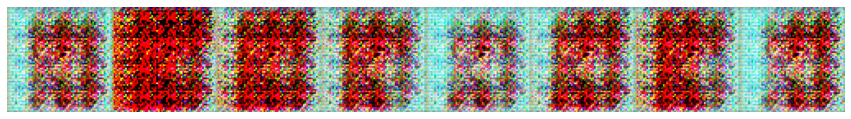

Epoch [   11/   50] | d_loss: 0.4752 | g_loss: 10.8633
Epoch [   12/   50] | d_loss: 0.4386 | g_loss: 5.0117
Epoch [   13/   50] | d_loss: 0.4510 | g_loss: 4.6921
Epoch [   14/   50] | d_loss: 0.4163 | g_loss: 6.9549
Epoch [   15/   50] | d_loss: 0.3810 | g_loss: 5.2872
Epoch [   16/   50] | d_loss: 0.3850 | g_loss: 4.7794
Epoch [   17/   50] | d_loss: 0.3617 | g_loss: 6.4061
Epoch [   18/   50] | d_loss: 0.3419 | g_loss: 5.8079
Epoch [   19/   50] | d_loss: 0.3839 | g_loss: 6.4608
Epoch [   20/   50] | d_loss: 0.3353 | g_loss: 6.1405


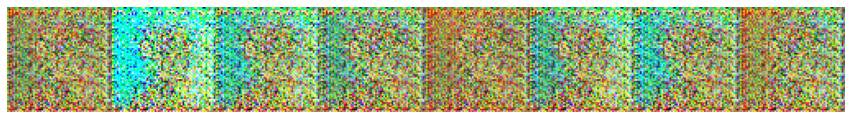

Epoch [   21/   50] | d_loss: 0.3459 | g_loss: 9.4766
Epoch [   22/   50] | d_loss: 0.4624 | g_loss: 1.9272
Epoch [   23/   50] | d_loss: 0.4583 | g_loss: 4.5735
Epoch [   24/   50] | d_loss: 2.2827 | g_loss: 10.0377
Epoch [   25/   50] | d_loss: 0.5316 | g_loss: 2.3675
Epoch [   26/   50] | d_loss: 0.4821 | g_loss: 3.7775
Epoch [   27/   50] | d_loss: 0.4295 | g_loss: 2.6885
Epoch [   28/   50] | d_loss: 0.9274 | g_loss: 2.7028
Epoch [   29/   50] | d_loss: 0.5239 | g_loss: 3.9367
Epoch [   30/   50] | d_loss: 0.3949 | g_loss: 3.3958


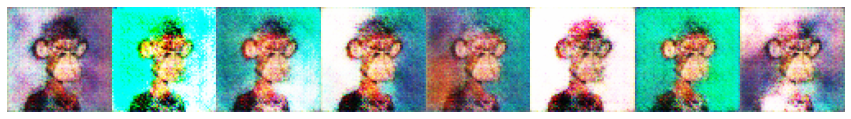

Epoch [   31/   50] | d_loss: 0.4205 | g_loss: 3.0256
Epoch [   32/   50] | d_loss: 0.9643 | g_loss: 5.4190
Epoch [   33/   50] | d_loss: 0.4649 | g_loss: 3.3320
Epoch [   34/   50] | d_loss: 0.3492 | g_loss: 4.5014
Epoch [   35/   50] | d_loss: 0.4174 | g_loss: 3.8984
Epoch [   36/   50] | d_loss: 0.4659 | g_loss: 3.3592
Epoch [   37/   50] | d_loss: 0.4353 | g_loss: 3.3117
Epoch [   38/   50] | d_loss: 0.4574 | g_loss: 2.8713
Epoch [   39/   50] | d_loss: 0.4846 | g_loss: 2.9226
Epoch [   40/   50] | d_loss: 0.4029 | g_loss: 2.8493


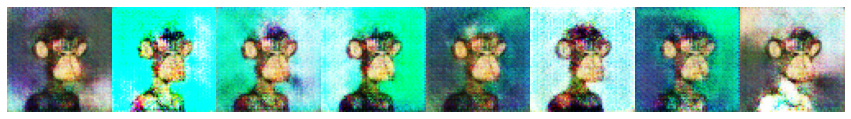

Epoch [   41/   50] | d_loss: 1.9443 | g_loss: 2.0605
Epoch [   42/   50] | d_loss: 0.8216 | g_loss: 0.6980
Epoch [   43/   50] | d_loss: 0.5415 | g_loss: 4.2490
Epoch [   44/   50] | d_loss: 1.5577 | g_loss: 3.2254
Epoch [   45/   50] | d_loss: 0.4945 | g_loss: 2.7305
Epoch [   46/   50] | d_loss: 0.7372 | g_loss: 1.6839
Epoch [   47/   50] | d_loss: 0.7112 | g_loss: 3.9444
Epoch [   48/   50] | d_loss: 0.4497 | g_loss: 2.3989
Epoch [   49/   50] | d_loss: 0.5494 | g_loss: 3.6865
Epoch [   50/   50] | d_loss: 0.9468 | g_loss: 0.5654


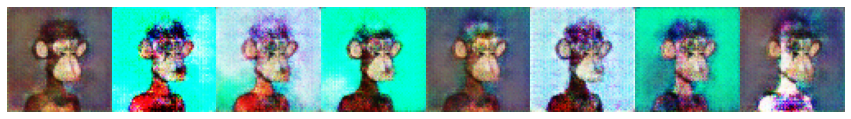

In [ ]:
%time
n_epochs = 50
train(discriminator,
      generator,
      n_epochs,
      dataloader,
      d_optimizer,
      g_optimizer,
      z_dim,
      print_every=10,
      device=device)

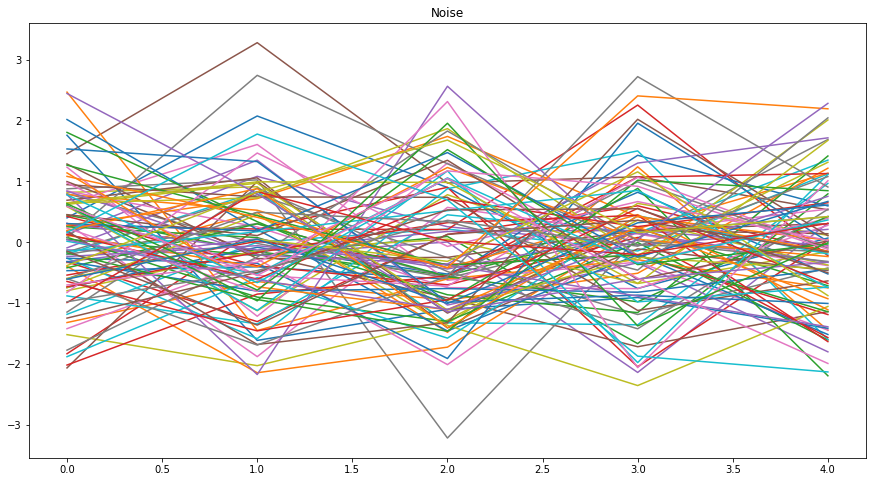

In [ ]:
plt.figure(figsize = (15, 8))
plt.plot(noise)
plt.title("Noise")
plt.show()


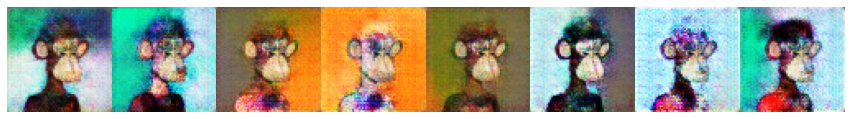

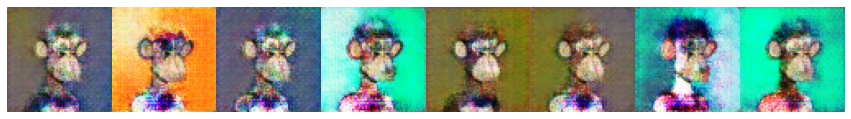

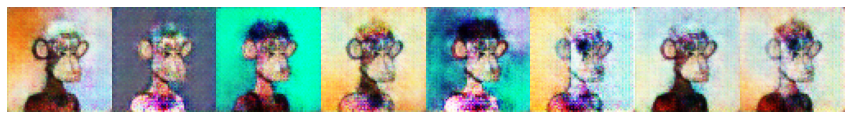

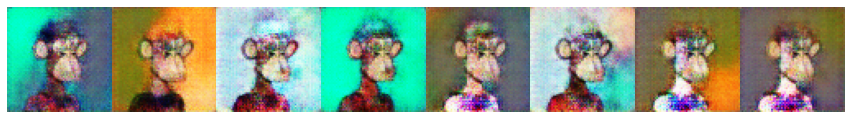

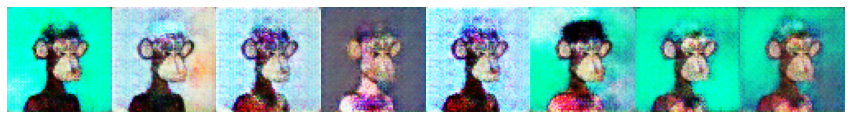

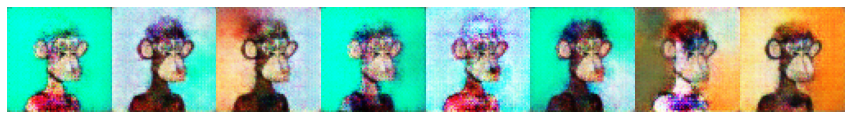

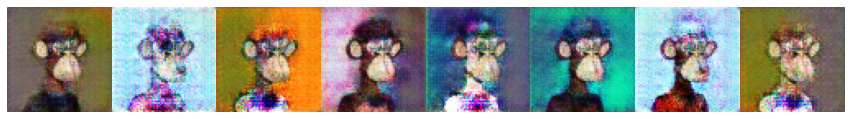

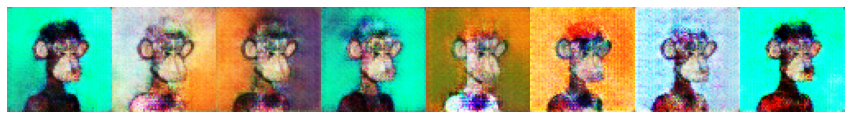

In [ ]:
generator.to(device)
generator.eval()       #eval mode
sample_size=8

for i in range(8):    
    
    #generate latent vectors
    fixed_z = Generator.get_noise(n_samples=sample_size, 
                                  z_dim=z_dim, 
                                  device=device)    
    
    #generate samples
    sample_image = generator(fixed_z)
    
    #display samples
    print_tensor_images(sample_image)